Mary Jane the Model
==============

***Using machine earning to reveal insights and predict performance of cannabis dispensaries***

**Author:** *Scott Butters*

# Abstract

In 2012, Washington state passed I-502 and legalized the recreational sale, use, and possession of marijuana. This event has led to an explosion of development in the field that's making waves through our society. Since 2014, approximately 500 state licensed dispensaries have opened throughout the state, with nearly 150 of those here in Seattle. And the thing that gets me excited is that because of regulations, a ton of their data is publicly available, meaning I got to play with it. We can go into the weeds later about how and why it took me a thousand websites and 4 different scraping techniques to get the data, and how my R^2 varied when I went shifted from 10-30 features to estimate the monthly revenue of a cannabis dispensary. But for now, let me tell you about what I learned as I immersed myself in this dataset over the past 2 weeks. In this project I scour the web for publicly available data that might be predictive of how a cannabis dispensary performs, such as customer reviews, inventory distributions, and local demographics. I then train machine learning models to predict a dispensary's monthly revenue and analyze the resulting models to distill insights about what drives sales in the marijuana market.


In this project, I explored the question of what makes the Washington recreational cannabis market tick. I decided that if I could identify the features that most contributed to a dispensary's revenue, I could get a lot of insight out of how the features shake out. 

When asked what my project was, I kept saying that it was to use web scraping to predict monthly revenue using linear regression. And it was, of course it was. But that's not the point, that's not the story. 

Here's the monthly revenue of all dispensaries for the last 16 months. See the trend?

Okay. Now. Here's the monthly revenue of a handful of dispensaries over that same period. See the trend?

But we can show this better. Here's the average monthly change in revenue of a dispensary.
Next to the change for the overall market. 
Next to variation in the S&P 500 over the same period.
And now the top marijuana ETF out there.

So if we're going to make choices about what to invest in to make a dispensary successful, we need to have the impacts of the external market in context. So I put those indicators in there for some regression models to see how significant a role they played.

In at attempt to both have more data and isolate the time component of my analysis, I constructed a new target variable, which is marketshare. For each month, I divided the revenue of a given dispensary by the revenue of all of the dispensaries over that period. 

# Obtain the Data

The data for this project is derived from several sources:

## Dispensary profiles from [Leafly](www.leafly.com)

Leafly is an information aggregator for cannabis. They maintain a profile for most of the dispensaries in the state. As part of my dataset, I've scraped the following features from the Leafly website for each dispensary for which it was available:

* Average customer rating and number of customer reviews
* Inventory counts (number of products under descriptions like "flower", "edibles", "concentrates", etc.
* Categorical qualities, such as whether or not the store is ADA accessible or has an ATM onsite
* Metadata such as name, address, phone number, etc.

The combination of these features gives us a profile of each dispensary that allow us to draw insights from our model into what makes for a successful dispensary.

## Demographics from [WA HomeTownLocator](https://washington.hometownlocator.com/)

Of course, having the best inventory, friendliest staff and prettiest building in the state doesn't amount to anything if a dispensary is in the middle of nowhere. This is where demographic data comes in. WA HomeTownLocator maintains a database of demographic statistics for nearly every zip code in the state of Washington. The data is produced by Esri Demographics, and updated 4 times per year using data from the federal census, IRS, USPS, as well as local data sources and more. From this website I scraped data likely to be predictive of a local market such as:

* Population density
* Diversity
* Average income

These data give our model an image of what a dispensary's customer base is like, allowing us to characterize what makes for a good location to establish a dispensary.

## [Washington State Liquor and Cannabis Board (WSLCB)](https://lcb.wa.gov/)

Lastly, all that data would get us nowhere if we didn't have any target data to train our models on. That's where the WSLCB comes in. The WSLCB maintains data on every dispensary in the state, including monthly reports of revenue (which is what our model is predicting). Their data is scattered across a couple of different outlets, but for this project I used spreadsheets downloadable from [this obsure page](https://lcb.wa.gov/records/frequently-requested-lists) to get sales data dating back to November 2017. Because the only identifying information in that spreadsheet is the license number of the dispensary, I also downloaded a spreadsheet listing metadata for every entity that has applied for a Marijuana license, which I then joined with the sales data in order to link it up with data scraped from other resources.

## Data Collection

The code below contains a pipeline to visit each of our sources and scrape or download all of the desired data into a few files stored in the data/raw/ directory to be scrubbed and processed later.

In [275]:
## %%writefile ../src/data/make_dataset.py

# Imports
import json
import os
import random
import re
import requests
import sys
import time

import numpy as np
import pandas as pd

from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

# Helper functions
def parse_products(text):
    '''
    Parses string of products into dictionary of products with counts
    Input: string of products as scraped from Leafly dispensary page
    Output: dictionary of {product: count} relationships
    '''
    repl = ['(', ')']
    for char in repl:
        text = text.replace(char, '')
    prod_list = text.split('\n')
    prod_list = [prod.strip().lower() for prod in prod_list]
    prod_dict = {}
    for i, element in enumerate(prod_list):
        if element.isnumeric():
            prod_dict[prod_list[i - 1]] = int(element)
        elif 'difference' in element:
            pass
        else:
            prod_dict[element.strip()] = 0
    return prod_dict


def scrape_disp(disp, driver, user_agent):
    """
    Scrapes dispensary-specific page on leafly for additional data and adds it
    to existing dictionary dataset
    Input: dictionary containing metadata for a single dispensary
    Output: dictionary with additional metadata for given dispensary
    """
    url = 'https://www.leafly.com/dispensary-info/'
    slug = disp['slug']
    url += slug
    
    if 'OR' in disp['formattedShortLocation']:
        return {}
    
    response  = requests.get(url, headers=user_agent)
    if not response.ok:
        print('Connection to {} failed'.format(disp['name']))
        return {}
    
    # Open page
    driver.get(url)
    
    # Confirm over 21
    try:
        yes_button = driver.find_element_by_xpath('//button[text()="Yes"]')
        yes_button.click()
    except:
        pass

    # Scrape categoricals
    try:
        cat_selector = driver.find_element_by_class_name('jsx-4153842418')
        # cat_selector = driver.find_element_by_tag_name('ul')
        items = cat_selector.find_elements_by_tag_name("li")
        categories = {item.text.lower(): True for item in items}
        disp.update(categories)
    except:
        print('Failed to scrape categories for {}'.format(disp['name']))
        pass

    # Scrape products
    try:
        products = driver.find_elements_by_class_name('jsx-1433915045')
        products_text = products[0].text
        product_dict = parse_products(products_text)
        disp.update(product_dict)
    except:
        print('Failed to scrape products for {}'.format(disp['name']))
        pass
    
    print('Successfully scraped {}'.format(disp['name']))
    return disp


def scrape_leafly_disps(path, disp_data_filename, data):
    """
    Gets JSON file of data on dispensaries from Leafly, either by loading
    pre-existing file or by re-scraping Leafly
    Input: path and filename for output file, index  of basic dispensary metadata
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
#     filepath = '../data/raw/dispensary_data.json'
    filepath = path + disp_data_filename
    if os.path.isfile(filepath):
        overwrite = input(
            '''Dispensaries data dict already exists. Scrape data again? y/n\n
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data

    print("Beginning scrape...")
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)

    for disp in data:
        new_data = scrape_disp(data[disp], driver, user_agent)
        data[disp].update(new_data)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
    
    return data


def retry(TL_lat, TL_lon, cell_size):
    '''
    If request hits Leafly API limit, split cell into 4 subcells and retry
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    '''
    TL_lats = [TL_lat, TL_lat - 0.4 * cell_size]
    TL_lons = [TL_lat, TL_lat + 0.4 * cell_size]
    disp_data = {}
    for lat, lon in zip(TR_lats, TR_lons):
        data = get_disp_data_by_coords(lat, lon, cell_size=0.6 * cell_size)
        disp_data.update(data)
    return disp_data


def get_disp_data_by_coords(TL_lat, TL_lon, cell_size=0.5):
    """
    Performs search for all dispensaries within a map region on Leafly
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    """
    # Setup
    BR_lat = TL_lat - cell_size
    BR_lon = TL_lon + cell_size
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    
    url = (
        'https://web-finder.leafly.com/api/searchThisArea?topLeftLat={}&topLeftLon={}&bottomRightLat={}&bottomRightLon={}&userLat=47.6&userLon=-122.3'
        ).format(TL_lat, TL_lon, BR_lat, BR_lon)
    
    # Scrape
    time.sleep(.5+2*random.random())
    r = requests.get(url)
    if r.status_code != 200:
        print('Leafly search failed at {}'.format(coords))
        return {}
    disps = r.json()
    
    # Parse
    fields = ['name', 'address1', 'address2', 'city', 'location', 'phone',
              'formattedShortLocation', 'medical', 'recreational', 'tier', 
              'lastMenuUpdate', 'starRating', 'numberOfReviews', 'slug']

    disp_data = {
        d['name']: {k: d[k] for k in fields} for d in disps['dispensaries']}
    entries = len(disp_data)
    
    # Check results; retry if necessary and return data
    if entries > 200:
        return retry(TR_lat, TR_lon, cell_size)
    elif entries < 1:
#         print('no results at {}'.format(coords))
        return {}
    else:
#         print('{} results found at {}'.format(len(disp_data), coords))
        return disp_data
    
    
def get_rect_disp_data(TL_lat, TL_lon, BR_lat, BR_lon, cell_size=0.5):
    """
    Performs grid search on sub-rectangles with slight overlap, gathering data 
    on each cell
    Input: lat/lon coords of top left and bottom right corners, as well as 
    optional cell size parameter (defaults to 0.5)
    Output: dictionary of dictionaries representing all dispensaries in
    rectangle
    """
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    max_step = 0.8 * cell_size
    lat_steps = np.ceil((TL_lat - BR_lat - cell_size) / max_step)
    lon_steps = np.ceil((BR_lon - TL_lon - cell_size) / max_step)

    TL_lats = np.linspace(TL_lat, BR_lat + cell_size, lat_steps + 1)
    TL_lons = np.linspace(TL_lon, BR_lon - cell_size, lon_steps + 1)

    disp_data = {}

    for lat in TL_lats:
        for lon in TL_lons:
            data = get_disp_data_by_coords(lat, lon, cell_size)
            disp_data.update(data)

    print('Total dispensaries found: ', len(disp_data))
    return disp_data


def get_disp_dict(path):
    """
    Performs a grid search across Washington for all dispensaries with an
    account on Leafly and scrapes metadata for each
    Input: relative path to raw data directory
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
    filepath = path + 'dispensary_list.json'
    
    if os.path.isfile(filepath):
        overwrite = input(
            '''Initial dispensary list already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data
    print("Beginning scrape...")
    
    # WA State bounding coordinates
    north = 49
    west = -124.8
    south = 45.4
    east = -116.8
    
    data = get_rect_disp_data(north, west, south, east, cell_size=1.4)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
        
    return data


def get_leafly_disp_data(path, disp_filename):
    """
    Steps through all helper functions to scrape data from Leafly
    Input: raw data path and desired filename for output
    Output: JSON file containing scraped data
    """
    disp_dict = get_disp_dict(path)
    disp_data = scrape_leafly_disps(path, disp_filename, disp_dict)
    return


def get_demo_data(path, license_filename, demo_filename):
    """
    Scrapes zip code based demographic data from washington.hometownlocator.com
    for all zip codes containing a dispensary found in WSLCB license data
    Input: relative path to raw data directory, license data filename, 
    demographics data filename
    Output: saves demographic dataset to csv in raw data directory
    """
    license_filepath = path + license_filename
    demo_filepath = path + demo_filename

    if os.path.isfile(demo_filepath):
        overwrite = input(
            '''Demographics file already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            return
    
    license_data = pd.read_excel(license_filepath, sheet_name=2, header=0)
    zips = license_data['ZipCode'].astype(str).str[:5].unique()
    demographics = pd.DataFrame()
    
    print("Beginning scrape...")
    for zip_code in sorted(zips):
        url = f'https://washington.hometownlocator.com/zip-codes/data,zipcode,{zip_code}.cfm'
        r = requests.get(url)
        if 'table' in r.text:
            df0, df1 = pd.read_html(url, index_col=0)[:2]
            df0.columns = [str(zip_code)]
            df1.columns = [str(zip_code)]
            df = pd.concat([df0, df1], axis=0).T.dropna(axis=1)
            df.drop(['INCOME', 'HOUSEHOLDS'], axis=1, inplace=True)
            demographics = pd.concat([demographics, df])
            print('Scraped {}/{} zips. Latest: {}'
                  .format(len(demographics), len(zips), zip_code), end='\r')
            sys.stdout.flush()
        else:
            print(f'\nNo data found for {zip_code}')
        
    demographics.to_csv(demo_filepath)
    print('Scraped data written to {}'.format(demo_filepath))
    return
    
    
def download_dataset(url, path, filename):
    """
    Downloads dataset from specified url and saves file to raw data directory
    Input: url from which to retrieve data, filename to store data in
    Output: dataset stored in raw data file directory
    """
#     filepath = '../data/raw/{}'.format(filename)
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        overwrite = input('{} already exists. Update? y/n'.format(filename))
        if overwrite.lower() != 'y':
            return
    print("Beginning file download...")
    r = requests.get(url)
    if not r.ok:
        print('Download failed')
        return
    with open(filepath, 'wb') as f:  
        f.write(r.content)
    print('File written to {}\n'.format(filepath))
    return
    
    
def get_sales_data(path, sales_filename, license_filename):
    """
    Gets links for most up-to-date dispensary sales and license information
    from WSLCB and downloads datasets
    Input:
    Output: downloaded files to raw data directory
    """
    # Get urls for most up-to-date sales and license data
    url = 'https://lcb.wa.gov/records/frequently-requested-lists'
    response = requests.get(url)
    if response.ok:
        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all('a')
        for link in links:
            if 'Traceability' in link.text:
                sales_url = link['href']
                print(f'\nLatest sales data found:\n{sales_url}')
                #filename = 'sales_data.xlsx'
                download_dataset(sales_url, path, sales_filename)
            elif 'Applicants' in link.text:
                licenses_url = link['href']
                print(f'\nLatest license data found:\n{licenses_url}')
                #filename = 'license_data.xls'
                download_dataset(licenses_url, path, license_filename)
    else:
        print('Failed to download sales data')

    return

    
def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    get_sales_data(path, sales_filename, license_filename)
    get_demo_data(path, license_filename, demo_filename)
    get_leafly_disp_data(path, disp_filename)
    
    print('\nData acquisition complete.\n')
    return

In [273]:
run()


Latest license data found:
https://lcb.wa.gov/sites/default/files/publications/Public_Records/2019/MarijuanaApplicants.xls
license_data.xls already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/license_data.xls

Latest sales data found:
https://lcb.wa.gov/sites/default/files/publications/Marijuana/sales_activity/2019-04-10-MJ-Sales-Activity-by-License-Number-Traceability-Contingency-Reporting.xlsx
sales_data.xlsx already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/sales_data.xlsx
Demographics file already exists. Scrape data again? y/nn
Initial dispensary list already exists. Scrape data again? y/nn
Dispensaries data dict already exists. Scrape data again? y/nn


# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [ ]:
## %%writefile ../src/features/build_features.py
# !pip install fuzzywuzzy
# !pip install python-Levenshtein

# Imports
import json
import re

import numpy as np
import pandas as pd

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

import matplotlib.pyplot as plt
%matplotlib inline

In [743]:
def build_features(path, filename):
    """
    make composite features that account for features existing
    """
    inpath = path['interim'] + filename['int_joined']
    outpath = path['processed'] + filename['processed']
    data = pd.read_pickle(inpath)
    
    
    
    
    
#     data.to_pickle(outpath)
    return data

In [745]:
data = build_features(path, filename)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 462
Data columns (total 68 columns):
reporting_period                   463 non-null datetime64[ns]
total_sales                        463 non-null float64
excise_tax_due                     463 non-null float64
name_x                             463 non-null object
address1_x                         463 non-null object
city_x                             463 non-null object
state                              463 non-null object
county                             463 non-null object
privdesc                           463 non-null object
privilegestatus                    463 non-null object
date_issued                        458 non-null datetime64[ns]
phone_x                            463 non-null object
zip_code                           463 non-null object
key_x                              463 non-null object
accessories                        11 non-null float64
ada_accessible                     278 non-null cate

In [759]:
data.columns

Index(['reporting_period', 'total_sales', 'excise_tax_due', 'city_x', 'state',
       'county', 'privilegestatus', 'date_issued', 'zip_code', 'accessories',
       'ada_accessible', 'all_products', 'atm', 'cartridges', 'city_y',
       'concentrates', 'debit_cards_accepted', 'edibles', 'flower',
       'last_menu_update', 'medical', 'name_y', 'number_of_reviews', 'other',
       'prerolls', 'recreational', 'seeds', 'star_rating', 'storefront',
       'topicals', 'ufcw_discount', 'veteran_discount', 'latitude',
       'longitude', 'total_population', 'population_in_households',
       'population_in_familes', 'population_in_group_qrtrs',
       'population_density', 'diversity_index', 'median_household_income',
       'average_household_income', 'per_capita_income', 'median_home_value',
       'average_home_value', 'total_households', 'average_household_size',
       'family_households', 'average_family_size', 'total_housing_units_#',
       'total_housing_units_%', 'owner_occupied_hous

In [777]:
def clean_joined_data(data):
    """
    Final clean of joined dataframe prior to feature engineering.
    Input: freshly joined dataframe
    Output: trimmed and cleaned dataframe retaining only elements that will be
    useful for building features and targets
    """
    # Drop rows and columns that are no longer useful
    data.dropna(axis=0, subset=['matched_key'], inplace=True)
    cols = ['name_x', 'address1_x', 'privdesc', 'phone_x', 'key_x', 'state',
            'county', 'address1_y', 'phone_y', 'slug', 'key_y', 'matched_key', 
            'score']
    data.drop(columns=cols, inplace=True)

    data.rename(columns={'name_y': 'name'}, inplace=True)
    data.set_index(keys='name', drop=True, inplace=True)
    
    return data
    

In [778]:
data = join_cleaned_data(path, filename)
display(data.head())
data.info()

,reporting_period,total_sales,excise_tax_due,city_x,privilegestatus,date_issued,zip_code,accessories,ada_accessible,all_products,atm,cartridges,city_y,concentrates,debit_cards_accepted,edibles,flower,last_menu_update,medical,number_of_reviews,other,prerolls,recreational,seeds,star_rating,...,latitude,longitude,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,total_housing_units_%,owner_occupied_housing_units_#,owner_occupied_housing_units_%,renter_occupied_housing_units_#,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Herbery - Chkalov,2019-02-01,380819.53,140903.23,VANCOUVER,ACTIVE (ISSUED),2018-12-12,98684,NaN,1.0,1273.0,1.0,NaN,Vancouver,456.0,NaN,344.0,224.0,2019-04-12 04:44:36.258522+00:00,0,19.0,64.0,185.0,1,NaN,4.389474,...,45.622034,-122.556848,30890.0,30822.0,25773.0,68.0,4366.0,50.0,69727.0,87442.0,31763.0,251142.0,285483.0,11194.0,2.75,8007.0,3.0,11717.0,100.0,6656.0,56.8,4538.0,38.7,523.0,4.5
Pend Oreille Cannabis Co.,2019-02-01,22331.20,8262.54,IONE,ACTIVE (ISSUED),2018-10-18,99139,NaN,1.0,341.0,1.0,NaN,Ione,64.0,1.0,45.0,167.0,2019-04-12 01:19:57.828847+00:00,0,12.0,5.0,60.0,1,NaN,5.000000,...,48.735902,-117.411832,1045.0,1045.0,828.0,0.0,4.0,16.0,51315.0,68580.0,29335.0,223056.0,259366.0,447.0,2.34,291.0,3.0,620.0,100.0,339.0,54.7,108.0,17.4,173.0,27.9
Pot Shop Seattle,2019-02-01,204078.23,75508.95,SEATTLE,PENDING (ISSUED),2018-09-08,98109,NaN,NaN,NaN,NaN,NaN,Seattle,NaN,NaN,NaN,NaN,2014-07-03 20:31:09.644930+00:00,0,22.0,NaN,NaN,1,NaN,4.700000,...,47.633840,-122.342054,27127.0,26279.0,10541.0,848.0,14311.0,49.0,80915.0,112727.0,68594.0,627801.0,732494.0,16336.0,1.61,4213.0,3.0,17786.0,100.0,4250.0,23.9,12086.0,68.0,1450.0,8.2
Fillabong 2 - Bremerton,2019-02-01,124285.72,45985.72,BREMERTON,ACTIVE (ISSUED),2018-09-13,98310,NaN,1.0,587.0,1.0,NaN,Bremerton,168.0,NaN,152.0,62.0,2019-04-12 04:42:46.938018+00:00,1,18.0,155.0,50.0,1,NaN,4.870370,...,47.593485,-122.613348,20140.0,19803.0,14090.0,337.0,3380.0,56.0,54181.0,70320.0,31405.0,254945.0,301018.0,8830.0,2.24,4820.0,3.0,9678.0,100.0,4419.0,45.7,4411.0,45.6,848.0,8.8
Green Tiki Cannabis Co,2019-02-01,76868.21,28441.24,KINGSTON,ACTIVE (ISSUED),2019-03-23,98346,NaN,1.0,NaN,1.0,NaN,Kingston,NaN,NaN,NaN,NaN,2017-05-08 22:48:24.362343+00:00,0,10.0,NaN,NaN,1,NaN,3.963333,...,47.811535,-122.540310,10487.0,10487.0,8678.0,0.0,344.0,38.0,80949.0,100612.0,39537.0,399702.0,448076.0,4121.0,2.54,2926.0,3.0,4556.0,100.0,3222.0,70.7,899.0,19.7,435.0,9.5


<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, The Herbery - Chkalov to Bud Barn
Data columns (total 54 columns):
reporting_period                   391 non-null datetime64[ns]
total_sales                        391 non-null float64
excise_tax_due                     391 non-null float64
city_x                             391 non-null object
privilegestatus                    391 non-null object
date_issued                        389 non-null datetime64[ns]
zip_code                           391 non-null object
accessories                        11 non-null float64
ada_accessible                     278 non-null category
all_products                       249 non-null float64
atm                                299 non-null category
cartridges                         36 non-null float64
city_y                             391 non-null object
concentrates                       232 non-null float64
debit_cards_accepted               44 non-null category
edibles                  

,total_sales,excise_tax_due,accessories,all_products,cartridges,concentrates,edibles,flower,number_of_reviews,other,prerolls,seeds,star_rating,topicals,latitude,longitude,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,total_housing_units_%,owner_occupied_housing_units_#,owner_occupied_housing_units_%,renter_occupied_housing_units_#,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%
accessories,-0.307877,-0.307877,1.000000,0.621830,0.439342,0.377845,0.277656,0.176510,-0.043216,0.952872,0.267848,NaN,-0.082457,0.856134,0.448278,-0.271945,-0.003106,-0.010550,0.012120,0.085659,-0.221609,-0.028191,-0.110531,-0.156158,-0.142429,-0.050465,-0.094564,-0.005506,-0.059838,0.051099,-0.063876,0.017476,NaN,-0.024934,-0.057248,0.016357,0.073658,0.395353,-0.044580
vacant_housing_units_%,-0.304105,-0.304105,-0.044580,-0.149895,-0.197241,-0.156699,-0.098696,-0.146717,-0.145618,-0.064862,-0.166727,NaN,-0.080040,-0.173091,0.057152,0.011855,-0.561403,-0.562151,-0.543393,-0.140428,-0.235896,-0.362637,-0.265296,-0.246634,-0.118914,-0.173739,-0.139399,-0.537543,-0.275448,-0.538151,-0.005717,-0.500385,NaN,-0.506575,-0.202789,-0.440782,-0.390745,0.202920,1.000000
latitude,-0.183130,-0.183130,0.448278,-0.026032,-0.065650,-0.038002,-0.026177,-0.067434,-0.016249,-0.099336,0.028958,NaN,-0.007478,-0.150318,1.000000,-0.023356,0.015557,0.021490,-0.004430,-0.069771,0.026697,-0.077467,0.133516,0.132488,0.163744,0.280724,0.284840,0.052607,-0.133089,0.016546,-0.099679,0.060390,NaN,0.048354,-0.005906,0.044463,-0.027116,0.129379,0.057152
owner_occupied_housing_units_%,-0.065529,-0.065529,-0.057248,-0.023254,0.051782,0.069149,-0.009790,0.022424,-0.047770,-0.114189,-0.010348,NaN,-0.030247,0.000531,-0.005906,-0.003037,-0.022037,0.008383,0.177910,-0.384924,-0.435581,-0.358433,0.403295,0.271234,0.022474,-0.044103,-0.052947,-0.107675,0.550043,0.162563,-0.066596,-0.122546,NaN,0.284662,1.000000,-0.506720,-0.822127,-0.250999,-0.202789
average_family_size,-0.042759,-0.042759,-0.063876,-0.102048,-0.081456,-0.081245,-0.080237,-0.107275,0.021371,-0.064478,-0.040896,NaN,-0.025900,-0.023203,-0.099679,0.029166,-0.137076,-0.136853,-0.103228,-0.039341,-0.282043,0.331802,-0.058072,-0.030845,-0.148618,-0.119219,-0.134045,-0.187118,0.304023,-0.137694,1.000000,-0.195455,NaN,-0.165162,-0.066596,-0.165547,0.065916,-0.207368,-0.005717
vacant_housing_units_#,0.001455,0.001455,0.395353,-0.093841,-0.298232,-0.176358,-0.075362,-0.148332,-0.026136,0.113164,-0.066413,NaN,0.019611,-0.330986,0.129379,-0.164743,0.451534,0.443424,0.383747,0.221500,0.135565,-0.089152,-0.125521,-0.075761,0.046106,0.094046,0.106181,0.497106,-0.265728,0.426439,-0.207368,0.553616,NaN,0.430155,-0.250999,0.449142,0.118775,1.000000,0.202920
population_in_group_qrtrs,0.017317,0.017317,0.085659,-0.045628,-0.023729,-0.080111,-0.107607,-0.035814,-0.033834,-0.016049,0.001980,NaN,0.074614,-0.056525,-0.069771,0.174578,0.303239,0.229477,0.078696,1.000000,0.150822,0.036722,-0.306449,-0.153351,-0.112641,0.069297,0.076103,0.293038,-0.226229,0.100127,-0.039341,0.298193,NaN,0.080536,-0.384924,0.452269,0.443412,0.221500,-0.140428
longitude,0.035012,0.035012,-0.271945,-0.017628,0.123268,0.036955,-0.073456,-0.013117,0.001959,-0.015462,-0.022898,NaN,-0.070931,-0.112707,-0.023356,1.000000,-0.061456,-0.076782,-0.065391,0.174578,-0.157648,-0.202264,-0.263812,-0.223013,-0.231677,-0.338053,-0.329044,-0.089104,0.047300,-0.074933,0.029166,-0.098123,NaN,-0.087490,-0.003037,-0.069251,-0.004264,-0.164743,0.011855
average_household_size,0.039647,0.039647,-0.059838,0.021973,0.116637,0.048968,-0.011344,0.082521,0.047108,-0.084865,0.004568,NaN,-0.050681,-0.004134,-0.133089,0.047300,0.113051,0.133627,0.308695,-0.226229,-0.444783,0.322742,0.081289,-0.053

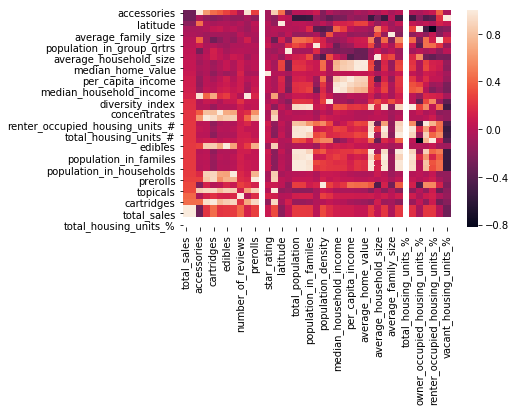

In [779]:
import seaborn as sns
corr = data.corr().sort_values(by='total_sales')
display(corr)
sns.heatmap(corr)

In [750]:
def make_key(row, fields):
    """
    Constructs a key from a simplified composite of a dispensary's name, city,
    and address
    Input: dataframe row (from apply function) along with a list of names of 
    fields to get key information from
    Output: lowercase string containing unique tokens from each of the fields 
    with punctuation removed and commonly shortened terms abbreviated
    """
    items = [row[f] for f in fields if isinstance(f, str)]
    joined = ' '.join(items).lower()
    remove = list('!@#$%^&*()-_+,./<>?[]{}')
    for char in remove:
        joined = joined.replace(char, '')
    
    abbr = {'street': 'st',
            'road': 'rd',
            'drive': 'dr',
            'highway': 'hwy',
            'avenue': 'ave',
            'boulevard': 'blvd',
            'suite': 'ste',
            'lane': 'ln',
            'northeast': 'ne',
            'southeast': 'se',
            'southwest': 'sw',
            'northwest': 'nw',
            'state route': 'sr',
            'llc': '',
            'wa20': 'sr 20',
            'us101': 'hwy 101',
            'wa14': 'hwy 14',
            'wa99': 'hwy 99',
            'stevens pass hwy': 'stevens pass hwy sr 2',
            'us395': 'hwy 395'
           }
    
    for token in abbr:
        joined = joined.replace(token, abbr[token])
    key = ' '.join(list(joined.split()))
    return key


def match_key(row, df, threshhold=65):
    """
    Uses fuzzy logic to find the closest matching key from a list of keys and
    the best match along with a score if above a specified threshhold
    Input: row of dataframe containing a key, dataframe containing column of
    target keys to match to, and optionally a threshhold specification, which
    is set to 65 by default
    Output: A tuple of the form (best_match_key, score). If no key surpasses
    the threshhold, (np.nan, max_score) is returned.
    """
    key = row['key']
    candidates = df['key']
    max_score = -1
    max_name = ""
    
    for f_key in candidates:
        score = fuzz.token_sort_ratio(key, f_key)
        if (score > threshhold) & (score > max_score):
            max_name = f_key
            max_score = score
    if max_score < threshhold:
        return (np.nan, max_score)
    return (max_name, max_score)


def join_cleaned_data(path, filename):
    """
    Join all cleaned data into a single dataframe and pickle
    Input: dictionaries containing paths and filenames for input/output files
    Output: pickled dataframe of all of the cleaned data
    """
    names = ['int_leafly', 'int_sales', 'int_demo']
    filepaths = [path['interim'] + filename[n] for n in names]
    leafly, sales, demo = [pd.read_pickle(f) for f in filepaths]

    # Construct composite key for joining with sales data
    key_fields = ['city', 'address1']
    leafly['key'] = leafly.apply(make_key, axis=1, fields=key_fields)
    sales['key'] = sales.apply(make_key, axis=1, fields=key_fields)

    leafly[['matched_key', 'score']] = leafly.apply(
        match_key, axis=1, df=sales).apply(pd.Series)
    
    # Merge leafly data into sales data
    data = pd.merge(
        sales, leafly, how='left', left_on='key', right_on='matched_key')

    ## merge demo data into sales data
    data = pd.merge(data, demo, how='left', on='zip_code')
    
    data = clean_joined_data(data)
    
    outpath = path['interim'] + filename['int_joined']
    data.to_pickle(outpath)
    return data


def join_sales_data(path, filename):
    """
    Loads sales and license data files and joins them into one table
    Also creates a column with zip code as a 5 digit string for later use
    Input:
    Output: returns merged dataframe
    """
    filepath = path['raw'] + filename['raw_sales']
    sales_data = pd.read_excel(filepath, sheet_name=0, header=3)
    sales_data.rename(columns={'License Number':'License #'}, inplace=True)
    sales_data.set_index(keys='License #', inplace=True)

    filepath = path['raw'] + filename['raw_license']
    license_data = pd.read_excel(filepath, sheet_name=2, header=0, index_col=1)

    data = pd.merge(sales_data, license_data, how='left', on='License #')
    return data  

    
def clean_wslcb_data(path, filename):
    """
    Loads, cleans, and joins raw license and sales data from WSLCB.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data from WSLCB
    """
    data = join_sales_data(path, filename)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'tradename': 'name', 
        'dateissued': 'date_issued',
        'dayphone': 'phone',
        'street_address': 'address1'
    }, inplace=True)

    data['zip_code'] = data['zipcode'].astype(str).str[:5]
    data['phone'] = data['phone'].astype(str).str[:-2]
    data['name'] = data['name'].str.strip().str.lower()

    data['reporting_period'] += '-01'
    date_cols = ['reporting_period', 'date_issued']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col], errors='coerce', yearfirst=True,
                                   infer_datetime_format=True)

    # Only working with most recent reporting period for now. Will have to
    # refactor this portion if past observations are integrated into the model
    recent = data['reporting_period'] == data['reporting_period'].max()
    data = data[recent]

    # Drop old columns we don't want anymore
    cols = ['ubi', 'suite/rm', 'zipcode']
    data.drop(columns=cols, inplace=True)
    
    # Drop rows without names
    data.dropna(subset=['name'], inplace=True)
    
    outpath = path['interim'] + filename['int_sales']
    data.to_pickle(outpath)
    return

    
def clean_demographic_data(path, filename):
    """
    Loads and cleans raw demographic data.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of demographic
    """
    raw_filename = path['raw'] + filename['raw_demo']
    int_filename = path['interim'] + filename['int_demo']

    data = pd.read_csv(raw_filename)

    # Reformat column
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'unnamed:_0': 'zip_code', 
        'population_density2': 'population_density',
        'diversity_index3': 'diversity_index',
        'owner_occupied_hu': 'owner_occupied_housing_units',
        'renter_occupied_hu': 'renter_occupied_housing_units'
    }, inplace=True)
    data['zip_code'] = data['zip_code'].astype(str)
    data.set_index('zip_code', drop=True, inplace=True)

    # Reformat columns with dollar strings into ints
    cols = ['median_household_income', 'average_household_income',
            'per_capita_income', 'median_home_value', 'average_home_value']
    for c in cols:
        data[c] = data[c].str.replace('$', '').str.replace(',', '').astype(int)

    # Split columns with number and percent values into separate columns
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    new_cols = {col:[f'{col}_#', f'{col}_%'] for col in cols}
    for old, new in new_cols.items():
        for char in list(',(%)'):
            data[old] = data[old].str.replace(char, '')
        data[new] = data[old].str.split().apply(pd.Series).astype(float)

    # Drop old columns we don't want anymore
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    data.drop(columns=cols, inplace=True)
    
    data.to_pickle(int_filename)
    return


def clean_leafly_data(path, filename):
    """
    Loads and cleans raw data scraped from Leafly.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data scraped from Leafly
    """
    raw_filename = path['raw'] + filename['raw_leafly']
    int_filename = path['interim'] + filename['int_leafly']

    # Read data from file to dataframe
    data = pd.read_json(raw_filename, orient='index')

    # Rename columns
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'formattedshortlocation': 'formatted_short_location', 
        'lastmenuupdate': 'last_menu_update',
        'numberofreviews': 'number_of_reviews',
        'pre-rolls': 'prerolls',
        'starrating': 'star_rating'
    }, inplace=True)

    # Filter to only Washington entries
    f = data['formatted_short_location'].str.contains('WA')
    data = data[f]

    # Cast menu update as datetime
    data['last_menu_update'] = pd.to_datetime(
        data['last_menu_update'], errors='coerce', infer_datetime_format=True)

    # Cast categorical features as such
    cat_cols = ['ada_accessible', 'atm', 'debit_cards_accepted', 'medical', 
                'recreational', 'storefront', 'ufcw_discount', 
                'veteran_discount']
    data[cat_cols] = data[cat_cols].astype('category')
    
    # Clean phone #
    for char in list('()-. '):
        data['phone'] = data['phone'].str.replace(char, '')
    data['phone'].replace([None], '', inplace=True)
    
    # Extact lat/lon coordinates into their own feature
    data[['latitude', 'longitude']] = data['location'].apply(pd.Series)
    
    # Drop old columns we don't want anymore
    cols = ['address2', 'formatted_short_location', 'location', 'tier']
    data.drop(columns=cols, inplace=True)
    
    # Pickle and return dataframe
    data.to_pickle(int_filename)
    return data

    
def run():
    """
    Executes a set of helper functions that read files from data/raw, 
    cleans them, and converts the data into a design matrix that is ready
    for modeling.
    """
    path = {
        'raw': '../data/raw/',
        'interim': '../data/interim/',
        'processed': '../data/processed/'
    }
    
    filename = {
        'raw_leafly': 'dispensary_data.json',
        'raw_demo': 'demographics.csv',
        'raw_license': 'license_data.xls',
        'raw_sales': 'sales_data.xlsx',
        'int_leafly': 'leafly.pkl',
        'int_demo': 'demographics.pkl',
        'int_sales': 'sales.pkl',
        'int_joined': 'joined_data.pkl',
        'processed': 'data.pkl'
    }
    
    clean_leafly_data(path, filename)
    clean_demographic_data(path, filename)
    clean_wslcb_data(path, filename)
    join_cleaned_data(path, filename)
    build_features(path, filename)
    
    print('\nData acquisition complete.\n')
    return

## Test here

In [741]:
run()


Cleaned Leafly data:


,accessories,ada_accessible,address1,all_products,atm,cartridges,city,concentrates,debit_cards_accepted,edibles,flower,last_menu_update,medical,name,number_of_reviews,other,phone,prerolls,recreational,seeds,slug,star_rating,storefront,topicals,ufcw_discount,veteran_discount,latitude,longitude
Mister Buds,NaN,NaN,536 Marine Dr,NaN,NaN,NaN,Port Angeles,NaN,NaN,NaN,NaN,2017-04-10 17:54:28.278868+00:00,0,Mister Buds,3,NaN,3607971966,NaN,1,NaN,mister-buds,5.000000,1.0,NaN,NaN,NaN,48.121985,-123.443722
Origins Port Angeles,NaN,1.0,1215 E Front Street,621.0,1.0,NaN,Port Angeles,176.0,NaN,175.0,115.0,2019-04-12 01:37:53.395365+00:00,0,Origins Port Angeles,26,29.0,3604064902,126.0,1,NaN,sparket-rnr,4.961538,1.0,NaN,NaN,1.0,48.111539,-123.411805
Cannabis Coast,NaN,NaN,193161 Highway 101,NaN,1.0,NaN,Forks,NaN,NaN,NaN,NaN,2016-04-07 23:37:15.980746+00:00,0,Cannabis Coast,2,NaN,3603744020,NaN,1,NaN,cannabis-coast,5.000000,1.0,NaN,NaN,NaN,47.968318,-124.404138
Lux Pot Shop - Ballard,NaN,1.0,4912 17th Ave NW,2849.0,1.0,NaN,Seattle,634.0,1.0,765.0,659.0,2019-04-12 00:37:20.749868+00:00,0,Lux Pot Shop - Ballard,52,49.0,2062945586,742.0,1,NaN,stash-pot-shop,4.358974,1.0,NaN,NaN,NaN,47.664842,-122.378641
Nature's Gifts - Sequim,NaN,1.0,755 W Washington St,618.0,1.0,NaN,Sequim,262.0,NaN,73.0,153.0,2019-04-12 03:17:37.187515+00:00,0,Nature's Gifts - Sequim,19,NaN,3607971993,130.0,1,NaN,natures-gifts-sequim,4.594737,1.0,NaN,NaN,1.0,48.079130,-123.120452



Cleaned demographic data:


,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,total_housing_units_%,owner_occupied_housing_units_#,owner_occupied_housing_units_%,renter_occupied_housing_units_#,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%
zip_code,,,,,,,,,,,,,,,,,,,,,,,
98002,35047,34605,26256,442,4906,70,47844,61905,24440,194413,208432,13599,2.54,8167,3,14495.0,100.0,6511.0,44.9,7088.0,48.9,896.0,6.2
98003,49533,48929,38209,604,4238,80,57052,76301,29554,278121,316089,18915,2.59,11705,3,19978.0,100.0,9320.0,46.7,9595.0,48.0,1063.0,5.3
98004,35086,34949,24385,137,4799,56,107731,158537,76582,1000431,1150686,16921,2.07,8508,3,20893.0,100.0,7651.0,36.6,9270.0,44.4,3972.0,19.0
98005,18904,18710,14550,194,2531,62,105278,146602,60616,707360,755712,7771,2.41,4858,3,8251.0,100.0,4250.0,51.5,3521.0,42.7,480.0,5.8
98006,40644,40394,35618,250,3800,59,126485,174989,62605,711450,782541,14492,2.79,11329,3,15041.0,100.0,11513.0,76.5,2979.0,19.8,549.0,3.7



Cleaned wslcb data:


,reporting_period,total_sales,excise_tax_due,name,address1,city,state,county,privdesc,privilegestatus,date_issued,phone,zip_code
License #,,,,,,,,,,,,,
71368,2019-02-01,380819.53,140903.23,the herbery,330 NE CHKALOV DR STE C & D,VANCOUVER,WA,CLARK,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-12-12,3609079694,98684
76189,2019-02-01,22331.20,8262.54,pend oreille cannabis co,124 RIVERSIDE AVE,IONE,WA,PEND OREILLE,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-10-18,5094423420,99139
79013,2019-02-01,204078.23,75508.95,pot shop,1628 DEXTER AVE N STE A,SEATTLE,WA,KING,MARIJUANA RETAILER,PENDING (ISSUED),2018-09-08,6145615684,98109
79720,2019-02-01,124285.72,45985.72,fillabong,3249 PERRY AVE STE B,BREMERTON,WA,KITSAP,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-09-13,3604432293,98310
81400,2019-02-01,76868.21,28441.24,green tiki cannabis,8208 NE STATE HIGHWAY 104,KINGSTON,WA,KITSAP,MARIJUANA RETAILER,ACTIVE (ISSUED),2019-03-23,3608810621,98346



Joined cleaned data:


,reporting_period,total_sales,excise_tax_due,name_x,address1_x,city_x,state,county,privdesc,privilegestatus,date_issued,phone_x,zip_code,key_x,accessories,ada_accessible,address1_y,all_products,atm,cartridges,city_y,concentrates,debit_cards_accepted,edibles,flower,...,matched_key,score,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,total_housing_units_%,owner_occupied_housing_units_#,owner_occupied_housing_units_%,renter_occupied_housing_units_#,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%
0,2019-02-01,380819.53,140903.23,the herbery,330 NE CHKALOV DR STE C & D,VANCOUVER,WA,CLARK,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-12-12,3609079694,98684,vancouver 330 ne chkalov dr ste c d,NaN,1.0,330 NE Chkalov Drive,1273.0,1.0,NaN,Vancouver,456.0,NaN,344.0,224.0,...,vancouver 330 ne chkalov dr ste c d,87.0,30890.0,30822.0,25773.0,68.0,4366.0,50.0,69727.0,87442.0,31763.0,251142.0,285483.0,11194.0,2.75,8007.0,3.0,11717.0,100.0,6656.0,56.8,4538.0,38.7,523.0,4.5
1,2019-02-01,22331.20,8262.54,pend oreille cannabis co,124 RIVERSIDE AVE,IONE,WA,PEND OREILLE,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-10-18,5094423420,99139,ione 124 riverside ave,NaN,1.0,124 Riverside Ave,341.0,1.0,NaN,Ione,64.0,1.0,45.0,167.0,...,ione 124 riverside ave,100.0,1045.0,1045.0,828.0,0.0,4.0,16.0,51315.0,68580.0,29335.0,223056.0,259366.0,447.0,2.34,291.0,3.0,620.0,100.0,339.0,54.7,108.0,17.4,173.0,27.9
2,2019-02-01,204078.23,75508.95,pot shop,1628 DEXTER AVE N STE A,SEATTLE,WA,KING,MARIJUANA RETAILER,PENDING (ISSUED),2018-09-08,6145615684,98109,seattle 1628 dexter ave n ste a,NaN,NaN,1628 Dexter Ave N,NaN,NaN,NaN,Seattle,NaN,NaN,NaN,NaN,...,seattle 1628 dexter ave n ste a,89.0,27127.0,26279.0,10541.0,848.0,14311.0,49.0,80915.0,112727.0,68594.0,627801.0,732494.0,16336.0,1.61,4213.0,3.0,17786.0,100.0,4250.0,23.9,12086.0,68.0,1450.0,8.2
3,2019-02-01,124285.72,45985.72,fillabong,3249 PERRY AVE STE B,BREMERTON,WA,KITSAP,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-09-13,3604432293,98310,bremerton 3249 perry ave ste b,NaN,1.0,3249 Perry Ave NE,587.0,1.0,NaN,Bremerton,168.0,NaN,152.0,62.0,...,bremerton 3249 perry ave ste b,84.0,20140.0,19803.0,14090.0,337.0,3380.0,56.0,54181.0,70320.0,31405.0,254945.0,301018.0,8830.0,2.24,4820.0,3.0,9678.0,100.0,4419.0,45.7,4411.0,45.6,848.0,8.8
4,2019-02-01,76868.21,28441.24,green tiki cannabis,8208 NE STATE HIGHWAY 104,KINGSTON,WA,KITSAP,MARIJUANA RETAILER,ACTIVE (ISSUED),2019-03-23,3608810621,98346,kingston 8208 ne state hwy 104,NaN,1.0,8202 NE State HWY 104,NaN,1.0,NaN,Kingston,NaN,NaN,NaN,NaN,...,kingston 8208 ne state hwy 104,97.0,10487.0,10487.0,8678.0,0.0,344.0,38.0,80949.0,100612.0,39537.0,399702.0,448076.0,4121.0,2.54,2926.0,3.0,4556.0,100.0,3222.0,70.7,899.0,19.7,435.0,9.5



Data acquisition complete.



In [737]:
names = ['int_leafly', 'int_sales', 'int_demo']
filepaths = [path['interim'] + filename[n] for n in names]
leafly, sales, demo = [pd.read_pickle(f) for f in filepaths]

demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 24 columns):
zip_code                           243 non-null int64
total_population                   243 non-null int64
population_in_households           243 non-null int64
population_in_familes              243 non-null int64
population_in_group_qrtrs          243 non-null int64
population_density                 243 non-null int64
diversity_index                    243 non-null int64
median_household_income            243 non-null int64
average_household_income           243 non-null int64
per_capita_income                  243 non-null int64
median_home_value                  243 non-null int64
average_home_value                 243 non-null int64
total_households                   243 non-null int64
average_household_size             243 non-null float64
family_households                  243 non-null int64
average_family_size                243 non-null int64
total_housing_units_#        

In [691]:
leafly.phone

Mister Buds                                          3607971966
Origins Port Angeles                                 3604064902
Cannabis Coast                                       3603744020
Lux Pot Shop - Ballard                               2062945586
Nature's Gifts - Sequim                              3607971993
Paper and Leaf - Bainbridge Island                   2067807814
South Bellingham Buds                                3607783358
Ruckus - Seattle                                     2062574805
Reefer Den                                           3603442510
Mary's - Seattle                                     2066877780
Sweet Relief - Mount Vernon                          3605882250
Rainier Cannabis - Mountlake Terrace                 4256780444
Lux Pot Shop - Lake City                             2064031673
Green 101                                            3605042238
The Reef - Seattle                                   2064666286
Uncle Ike's - Capitol Hill              

## Scratch Setup (delete from here down)

In [488]:
pd.set_option('max_columns', 50)
path = {
    'raw': '../data/raw/',
    'interim': '../data/interim/',
    'processed': '../data/processed/'
}
    
filename = {
    'raw_leafly': 'dispensary_data.json',
    'raw_demo': 'demographics.csv',
    'raw_license': 'license_data.xls',
    'raw_sales': 'sales_data.xlsx',
    'int_leafly': 'leafly.pkl',
    'int_demo': 'demographics.pkl',
    'int_sales': 'sales.pkl',
    'int_joined': 'joined_data.pkl',
    'processed': 'data.pkl'
}

## Cleaning Leafly

In [549]:
raw_filename = path['raw'] + filename['raw_leafly']
int_filename = path['interim'] + filename['int_leafly']

# Read data from file to dataframe
data = pd.read_json(raw_filename, orient='index')

# Rename columns
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.rename(columns={
    'formattedshortlocation': 'formatted_short_location', 
    'lastmenuupdate': 'last_menu_update',
    'numberofreviews': 'number_of_reviews',
    'pre-rolls': 'prerolls',
    'starrating': 'star_rating'
}, inplace=True)

# Filter to only Washington entries
f = data['formatted_short_location'].str.contains('WA')
data = data[f]

# Cast menu update as datetime
data['last_menu_update'] = pd.to_datetime(
    data['last_menu_update'], errors='coerce', infer_datetime_format=True)

# Cast categorical features as such
cat_cols = ['ada_accessible', 'atm', 'debit_cards_accepted', 'medical', 
            'recreational', 'storefront', 'ufcw_discount', 
            'veteran_discount']
data[cat_cols] = data[cat_cols].astype('category')

# Extact lat/lon coordinates into their own feature
data[['latitude', 'longitude']] = data['location'].apply(pd.Series)

Index(['accessories', 'ada_accessible', 'address1', 'address2', 'all_products',
       'atm', 'cartridges', 'city', 'concentrates', 'debit_cards_accepted',
       'edibles', 'flower', 'formatted_short_location', 'last_menu_update',
       'location', 'medical', 'name', 'number_of_reviews', 'other', 'phone',
       'prerolls', 'recreational', 'seeds', 'slug', 'star_rating',
       'storefront', 'tier', 'topicals', 'ufcw_discount', 'veteran_discount',
       'latitude', 'longitude'],
      dtype='object')


,accessories,ada_accessible,address1,address2,all_products,atm,cartridges,city,concentrates,debit_cards_accepted,edibles,flower,formatted_short_location,last_menu_update,location,medical,name,number_of_reviews,other,phone,prerolls,recreational,seeds,slug,star_rating,storefront,tier,topicals,ufcw_discount,veteran_discount,latitude,longitude
Mister Buds,NaN,NaN,536 Marine Dr,None,NaN,NaN,NaN,Port Angeles,NaN,NaN,NaN,NaN,"Port Angeles, WA",2017-04-10 17:54:28.278868+00:00,"{'lat': 48.1219849, 'lon': -123.4437221}",0,Mister Buds,3,NaN,(360) 797-1966,NaN,1,NaN,mister-buds,5.000000,1.0,900,NaN,NaN,NaN,48.121985,-123.443722
Origins Port Angeles,NaN,1.0,1215 E Front Street,None,621.0,1.0,NaN,Port Angeles,176.0,NaN,175.0,115.0,"Port Angeles, WA",2019-04-12 01:37:53.395365+00:00,"{'lat': 48.1115394, 'lon': -123.4118052}",0,Origins Port Angeles,26,29.0,360.406.4902,126.0,1,NaN,sparket-rnr,4.961538,1.0,300,NaN,NaN,1.0,48.111539,-123.411805
Cannabis Coast,NaN,NaN,193161 Highway 101,None,NaN,1.0,NaN,Forks,NaN,NaN,NaN,NaN,"Forks, WA",2016-04-07 23:37:15.980746+00:00,"{'lat': 47.9683179, 'lon': -124.404138}",0,Cannabis Coast,2,NaN,(360) 374-4020,NaN,1,NaN,cannabis-coast,5.000000,1.0,900,NaN,NaN,NaN,47.968318,-124.404138
Lux Pot Shop - Ballard,NaN,1.0,4912 17th Ave NW,None,2849.0,1.0,NaN,Seattle,634.0,1.0,765.0,659.0,"Seattle, WA",2019-04-12 00:37:20.749868+00:00,"{'lat': 47.6648419, 'lon': -122.3786413}",0,Lux Pot Shop - Ballard,52,49.0,206-294-5586,742.0,1,NaN,stash-pot-shop,4.358974,1.0,200,NaN,NaN,NaN,47.664842,-122.378641
Nature's Gifts - Sequim,NaN,1.0,755 W Washington St,Suite C,618.0,1.0,NaN,Sequim,262.0,NaN,73.0,153.0,"Sequim, WA",2019-04-12 03:17:37.187515+00:00,"{'lat': 48.0791305, 'lon': -123.1204523}",0,Nature's Gifts - Sequim,19,NaN,360-797-1993,130.0,1,NaN,natures-gifts-sequim,4.594737,1.0,300,NaN,NaN,1.0,48.079130,-123.120452


## Cleaning Demo Data

In [541]:
raw_filename = path['raw'] + filename['raw_demo']
int_filename = path['interim'] + filename['int_demo']

data = pd.read_csv(raw_filename)

# Reformat column
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.rename(columns={
    'unnamed:_0': 'zip_code', 
    'population_density2': 'population_density',
    'diversity_index3': 'diversity_index',
    'owner_occupied_hu': 'owner_occupied_housing_units',
    'renter_occupied_hu': 'renter_occupied_housing_units'
}, inplace=True)
data.set_index('zip_code', drop=True, inplace=True)

# Reformat columns with dollar strings into ints
cols = ['median_household_income', 'average_household_income',
        'per_capita_income', 'median_home_value', 'average_home_value']
for c in cols:
    data[c] = data[c].str.replace('$', '').str.replace(',', '').astype(int)

# Split columns with number and percent values into separate columns
cols = ['total_housing_units', 'owner_occupied_housing_units', 
        'renter_occupied_housing_units', 'vacant_housing_units']
new_cols = {col:[f'{col}_#', f'{col}_%'] for col in cols}
for old, new in new_cols.items():
    for char in list(',(%)'):
        data[old] = data[old].str.replace(char, '')
    print(old, new)
    data[new] = data[old].str.split().apply(pd.Series).astype(float)

# Drop old columns we don't want anymore
cols = ['total_housing_units', 'owner_occupied_housing_units', 
        'renter_occupied_housing_units', 'vacant_housing_units']
data.drop(columns=cols, inplace=True)

total_housing_units ['total_housing_units_#', 'total_housing_units_%']
owner_occupied_housing_units ['owner_occupied_housing_units_#', 'owner_occupied_housing_units_%']
renter_occupied_housing_units ['renter_occupied_housing_units_#', 'renter_occupied_housing_units_%']
vacant_housing_units ['vacant_housing_units_#', 'vacant_housing_units_%']


,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,total_housing_units_%,owner_occupied_housing_units_#,owner_occupied_housing_units_%,renter_occupied_housing_units_#,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%
zip_code,,,,,,,,,,,,,,,,,,,,,,,
98002,35047,34605,26256,442,4906,70,47844,61905,24440,194413,208432,13599,2.54,8167,3,14495.0,100.0,6511.0,44.9,7088.0,48.9,896.0,6.2
98003,49533,48929,38209,604,4238,80,57052,76301,29554,278121,316089,18915,2.59,11705,3,19978.0,100.0,9320.0,46.7,9595.0,48.0,1063.0,5.3
98004,35086,34949,24385,137,4799,56,107731,158537,76582,1000431,1150686,16921,2.07,8508,3,20893.0,100.0,7651.0,36.6,9270.0,44.4,3972.0,19.0
98005,18904,18710,14550,194,2531,62,105278,146602,60616,707360,755712,7771,2.41,4858,3,8251.0,100.0,4250.0,51.5,3521.0,42.7,480.0,5.8
98006,40644,40394,35618,250,3800,59,126485,174989,62605,711450,782541,14492,2.79,11329,3,15041.0,100.0,11513.0,76.5,2979.0,19.8,549.0,3.7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 98002 to 99403
Data columns (total 23 columns):
total_population                   243 non-null int64
population_in_households           243 non-null int64
population_in_familes              243 non-null int64
population_in_group_qrtrs          243 non-null int64
population_density                 243 non-null int64
diversity_index                    243 non-null int64
median_household_income            243 non-null int64
average_household_income           243 non-null int64
per_capita_income                  243 non-null int64
median_home_value                  243 non-null int64
average_home_value                 243 non-null int64
total_households                   243 non-null int64
average_household_size             243 non-null float64
family_households                  243 non-null int64
average_family_size                243 non-null int64
total_housing_units_#              243 non-null float64
total_housing_units_%

In [540]:
data.columns

Index(['total_population', 'population_in_households', 'population_in_familes',
       'population_in_group_qrtrs', 'population_density', 'diversity_index',
       'median_household_income', 'average_household_income',
       'per_capita_income', 'total_housing_units',
       'owner_occupied_housing_units', 'renter_occupied_housing_units',
       'vacant_housing_units', 'median_home_value', 'average_home_value',
       'total_households', 'average_household_size', 'family_households',
       'average_family_size', 'total_housing_units_#', 'total_housing_units_%',
       'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
       'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
       'vacant_housing_units_#', 'vacant_housing_units_%'],
      dtype='object')

## Cleaning Sales and License data

In [481]:
sales_data.columns

Index(['reporting_period', 'total_sales', 'excise_tax_due', 'name', 'ubi',
       'street_address', 'suite/rm', 'city', 'state', 'county', 'zipcode',
       'privdesc', 'privilegestatus', 'dateissued', 'dayphone', 'zip_code'],
      dtype='object')

In [473]:
sales_data.columns.str.lower()

Index(['reporting period', 'total sales', 'excise tax due', 'tradename', 'ubi',
       'street address', 'suite/rm', 'city', 'state', 'county', 'zipcode',
       'privdesc', 'privilegestatus', 'dateissued', 'dayphone', 'zip_code'],
      dtype='object')

In [484]:
sales_data = join_sales_data(path, filename)
sales_data.columns = sales_data.columns.str.lower().str.replace(' ', '_')
sales_data.rename(columns={
    'tradename': 'name', 
    'dateissued': 'date_issued',
    'dayphone': 'phone',
}, inplace=True)

sales_data['zip_code'] = sales_data['zipcode'].astype(str).str[:5]
sales_data['name'] = sales_data['name'].str.strip().str.lower()
sales_data['address1'] = sales_data['street_address'] + sales_data['suite/rm']

sales_data['reporting_period'] += '-01'
date_cols = ['reporting_period', 'date_issued']
for col in date_cols:
    sales_data[col] = pd.to_datetime(sales_data[col], errors='coerce', 
                                     yearfirst=True, infer_datetime_format=True)

recent = sales_data['reporting_period'] == sales_data['reporting_period'].max()
recent_sales = sales_data[recent]
display(recent_sales.sort_values(by='name').head(20))
recent_sales.info()

,reporting_period,total_sales,excise_tax_due,name,ubi,street_address,suite/rm,city,state,county,zipcode,privdesc,privilegestatus,date_issued,phone,zip_code,address1
License #,,,,,,,,,,,,,,,,,
414884,2019-02-01,237642.93,87927.88,#hashtag,6.033581e+15,3540 STONE WAY N,,SEATTLE,WA,KING,981038924.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-11-29,3.608184e+09,98103,3540 STONE WAY N ...
423413,2019-02-01,463721.35,171576.90,112th street cannabis,6.033492e+15,5809 112TH ST E BLDG B,,PUYALLUP,WA,PIERCE,983734323.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-12-22,2.069924e+09,98373,5809 112TH ST E BLDG B ...
364799,2019-02-01,217209.85,80367.64,2020 solutions edmonds,6.035723e+15,7207 212TH ST SW,,EDMONDS,WA,SNOHOMISH,980207735.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2019-03-26,3.609155e+09,98020,7207 212TH ST SW ...
422239,2019-02-01,60398.07,22347.29,2020 solutions ephrata,6.035723e+15,1615 BASIN ST SW,,EPHRATA,WA,GRANT,988232134.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-12-08,3.609155e+09,98823,1615 BASIN ST SW ...
422363,2019-02-01,27246.27,10081.12,2020 solutions soap lake,6.035723e+15,261 STATE HWY 28 WEST,,SOAP LAKE,WA,GRANT,988510000.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-12-08,3.609155e+09,98851,261 STATE HWY 28 WEST ...
422701,2019-02-01,4795.38,1774.29,2020 solutions sprague,6.036007e+15,209 E 4TH ST SUITE B,,SPRAGUE,WA,LINCOLN,990320000.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2019-03-26,2.534052e+09,99032,209 E 4TH ST SUITE B ...
425128,2019-02-01,13244.29,4900.39,20after4,6.033493e+15,302 HAZEL ST,,KELSO,WA,COWLITZ,986261410.0,MARIJUANA RETAILER,PENDING (ISSUED),2018-11-22,2.069293e+09,98626,302 HAZEL ST ...
423784,2019-02-01,203110.98,75151.06,365 recreational cannabis,6.034297e+15,17517 15TH AVE NE #B,,SHORELINE,WA,KING,981553801.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2018-07-19,4.259194e+09,98155,17517 15TH AVE NE #B ...
422099,2019-02-01,55461.39,20520.71,365 recreational cannabis,6.041521e+15,36711 U.S. HIGHWAY 12,,DAYTON,WA,COLUMBIA,983288622.0,MARIJUANA RETAILER,ACTIVE (ISSUED),2019-04-03,5.093823e+09,98328,36711 U.S. HIGHWAY 12 ...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 71368 to 428005
Data columns (total 17 columns):
reporting_period    417 non-null datetime64[ns]
total_sales         417 non-null float64
excise_tax_due      417 non-null float64
name                415 non-null object
ubi                 415 non-null float64
street_address      415 non-null object
suite/rm            415 non-null object
city                415 non-null object
state               415 non-null object
county              415 non-null object
zipcode             415 non-null float64
privdesc            415 non-null object
privilegestatus     415 non-null object
date_issued         410 non-null datetime64[ns]
phone               415 non-null float64
zip_code            417 non-null object
address1            415 non-null object
dtypes: datetime64[ns](2), float64(5), object(10)
memory usage: 58.6+ KB


In [584]:
data = join_sales_data(path, filename)
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.rename(columns={
    'tradename': 'name', 
    'dateissued': 'date_issued',
    'dayphone': 'phone',
    'street_address': 'address1'
}, inplace=True)

data['zip_code'] = data['zipcode'].astype(str).str[:5]
data['phone'] = data['phone'].astype(str).str[:-2]
data['name'] = data['name'].str.strip().str.lower()

data['reporting_period'] += '-01'
date_cols = ['reporting_period', 'date_issued']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce', yearfirst=True,
                               infer_datetime_format=True)

# Only working with most recent reporting period for now. Will have to
# refactor this portion if past observations are integrated into the model
recent = data['reporting_period'] == data['reporting_period'].max()
data = data[recent]

data.dropna(subset=['name'], inplace=True)

# Drop old columns we don't want anymore
cols = ['ubi', 'suite/rm', 'zipcode']
data.drop(columns=cols, inplace=True)

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [ ]:
## %%writefile ../src/visualization/visualize.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [ ]:
## %%writefile ../src/models/train_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    # data = load_features('data/processed/')
    # train, test = train_test_split(data)
    # save_train_test(train, test, 'data/processed/')
    # model = build_model()
    # model.fit(train)
    # save_model(model, 'models/')
    pass


In [ ]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between
    features.
    """
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_